# Tutorial 'QC, topographical analysis and segmentaton-free of Spot-based transcriptomics data'

This is the fast lane of the tutorial. Just start a session and click 'run the whole notebook' on the top to start executing.

UMAP calculation takes a few minutes, which we can use in the main notebook to get familiar with the general exploratory workflow.

In [1]:
# widens the screen:

%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../..'))

In [2]:
# imports, define a handy figure function:

import plankton.plankton as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

def figure(width=8,height=8):
    plt.figure(figsize=(width,height))


In [3]:
# load background stain:


um_p_px=0.325

coordinates = pd.read_csv('./data/in_situ_sequencing/coordinates.csv')
bg = -plt.imread('background.jpg').mean(-1)
bg = (bg-bg.min())/(bg.max()-bg.min())
bg_map = pl.PixelMap(pixel_data=bg,
                     cmap='Greys',
                     px_p_um = 0.504/um_p_px)
del bg

In [4]:
rands = np.random.rand(3000,2,)*np.array([coordinates.Global_x_pos.values.max(),coordinates.Global_y_pos.values.max()])

x = np.hstack([coordinates.Global_x_pos.values,rands[:,0]])
y = np.hstack([coordinates.Global_y_pos.values,rands[:,1]])

rand_genes = coordinates.Gene.values[np.random.randint(len(coordinates.Gene.unique()), size=(rands.shape[0]))]
g = np.hstack([coordinates.Gene.values,rand_genes])

In [8]:
sdata

,g,x,y,gene_id,noise
1,FLT1,288.209908,595.396532,47,False
2,JAG2,424.651884,577.204269,69,False
3,RSPO2,431.149120,605.792112,107,False
7,SFRP1,472.731437,620.735757,112,False
11,SOX17,475.980055,620.410895,118,False
...,...,...,...,...,...
497142,SOX17,328.209287,2560.120283,118,True
497143,HEYL,952.506075,972.610125,61,True
497146,IGFBP7,2475.539991,1447.987812,66,True
497147,SEC11C,2291.333382,1858.311716,111,True


In [16]:
sdata = pl.SpatialData(x_coordinates=x*um_p_px,
                       y_coordinates=y*um_p_px,
                       genes=g,
                       pixel_maps={'DAPI':bg_map}
                      )

In [17]:
sdata['noise']=False
sdata.loc[len(sdata)-rands.shape[0]:,'noise']=True

sdata = sdata[sdata.stats.progressive_sample(1.1)].spatial[100:2800,1000:]

In [18]:
# Parameterization for data cleaning/artefact removal:`

import time

knn_neighbors=250
bandwidth=5
n_neighbors=30
metric='euclidean'
min_dist=0.02
random_state=42
zero_weight=0.0
cutoff=15

_=sdata.graph.update_knn(n_neighbors=knn_neighbors)


t = time.perf_counter()
sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight,cutoff=cutoff)
t = (time.perf_counter()-t)
print(t)

Reducing dimensions with FastICA


/home/sebastian/anaconda3/envs/plankton-dev/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Calculating UMAP embedding.
289.12561759597156


In [8]:
assert False

AssertionError: 

In [12]:
sdata

,g,x,y,gene_id,noise
1,FLT1,288.209908,595.396532,47,False
2,JAG2,424.651884,577.204269,69,False
3,RSPO2,431.149120,605.792112,107,False
7,SFRP1,472.731437,620.735757,112,False
11,SOX17,475.980055,620.410895,118,False
...,...,...,...,...,...
497142,SOX17,328.209287,2560.120283,118,True
497143,HEYL,952.506075,972.610125,61,True
497146,IGFBP7,2475.539991,1447.987812,66,True
497147,SEC11C,2291.333382,1858.311716,111,True


In [ ]:
sdata.save('tutorial-umap.pl')

Text(0.5, 0.98, 'nbrs:30-cutoff:9-bw:6-t:289')

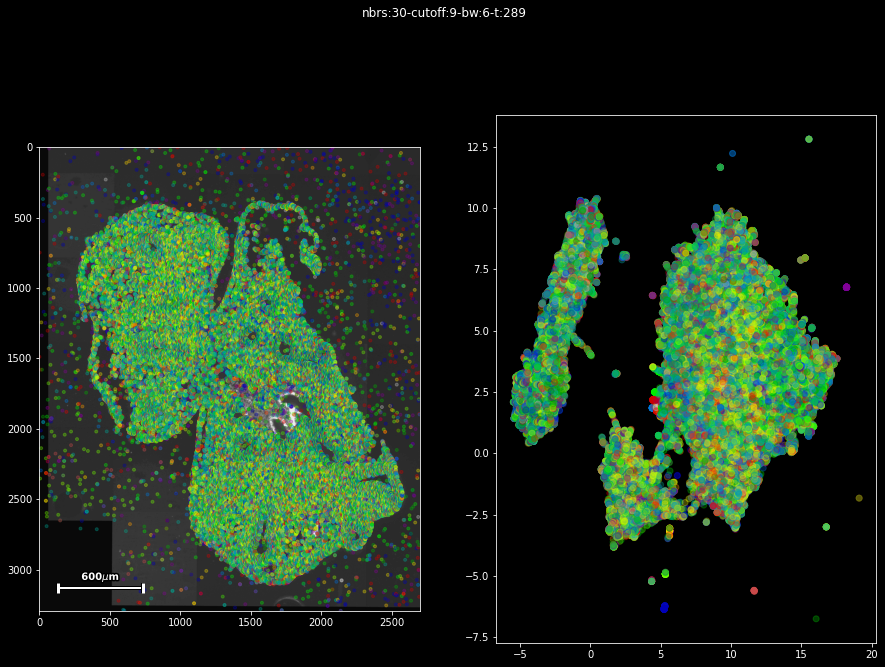

In [22]:
plt.figure(figsize=(15,15))

sdata[~sdata.noise].graph.map_and_umap(alpha=0.3)
plt.suptitle(f"nbrs:{n_neighbors}-cutoff:{cutoff}-bw:{bandwidth}-t:{int(t)}")

In [23]:
sdata.graph.umap_js()

    'data': [{'hoverinfo': 'none',
              'marker': {'colo…

In [ ]:
sdata[~sdata.bg_noise].scatter()

# unsupervised approach using SSAM-denovo

In [ ]:
from plankton.utils import localmax_sampling,ssam

# create a signature matrix through local-max sampling
signatures = pd.DataFrame(localmax_sampling(sdata,n_clusters=10,bandwidth=4),columns=sdata.genes)



In [ ]:
sdata_epi = sdata[~sdata.bg_noise & (sdata.inner_ducts_1|sdata.inner_ducts_2)]

In [ ]:
figure()

from plankton.utils import hbar_compare

hbar_compare(sdata[sdata.noise].stats, sdata[~sdata.noise].stats,('noise','signal'))

In [ ]:
# Parameterization for data cleaning/artefact removal:`

import time

knn_neighbors=250
bandwidth=25
n_neighbors=100
metric='cosine'
min_dist=0.2
random_state=42
zero_weight=0.0
cutoff=30

_=sdata_epi.graph.update_knn(n_neighbors=knn_neighbors)


t = time.perf_counter()
sdata_epi.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight,cutoff=cutoff)
print(time.perf_counter()-t)


In [ ]:
sdata_epi.graph.map_and_umap()

In [ ]:
sdata_epi.graph.umap_js()